## Prepare NDVI from MODIS Data

In this notebook, 16-daily MODIS/Terra NDVI data from 2000 - 2024 is processed. The following steps are included:
- Replace fill value with NA
- Mask pixels based on quality flags
- Crop to forest area
- Save datasets for needleleaved and broadleaved forests
- Save information on quality flags and counts of high quality pixels per year as csv datasets

In [1]:
# import libraries
import os
import warnings
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# read MODIS NDVI data
ndvi_full = xr.open_dataset("./Raw/NDVI_MODIS/MOD13A1.061_500m_aid0001.nc", decode_coords="all", decode_times=True)

In [5]:
# note that all dates from 2000-2024 are stored in one large netCDF dataset
ndvi_full

<xarray.Dataset> Size: 38GB
Dimensions:                   (time: 572, lat: 1871, lon: 2203)
Coordinates:
    crs                       int8 1B ...
  * time                      (time) object 5kB 2000-02-18 00:00:00 ... 2024-...
  * lat                       (lat) float64 15kB 55.06 55.06 ... 47.27 47.27
  * lon                       (lon) float64 18kB 5.865 5.869 ... 15.04 15.04
Data variables:
    _500m_16_days_NDVI        (time, lat, lon) float64 19GB ...
    _500m_16_days_VI_Quality  (time, lat, lon) float64 19GB ...
Attributes:
    title:        MOD13A1.061 for aid0001
    Conventions:  CF-1.6
    institution:  Land Processes Distributed Active Archive Center (LP DAAC)
    source:       AppEEARS v3.71
    references:   See README.md
    history:      See README.md

In [6]:
# convert CFTime index to datetime index
datetimeindex = ndvi_full.indexes['time'].to_datetimeindex()
ndvi_full['time'] = datetimeindex

C:\Users\irish\AppData\Local\Temp\ipykernel_14724\3536868753.py:2: FutureWarning: In a future version of xarray to_datetimeindex will default to returning a 'us'-resolution DatetimeIndex instead of a 'ns'-resolution DatetimeIndex. This warning can be silenced by explicitly passing the `time_unit` keyword argument.
  datetimeindex = ndvi_full.indexes['time'].to_datetimeindex()


In [7]:
# rename variables
ndvi_full = ndvi_full.rename({"_500m_16_days_NDVI":"NDVI", "_500m_16_days_VI_Quality":"QA"})

In [8]:
# check crs
ndvi_full.rio.crs

CRS.from_wkt('GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]')

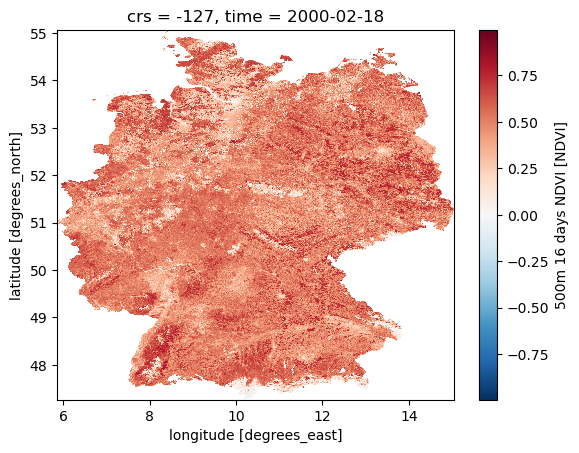

In [9]:
# plot exemplary NDVI and Quality Flag data of one date to get a first impression
ndvi_full.NDVI.sel(time = "2000-02-18").plot()

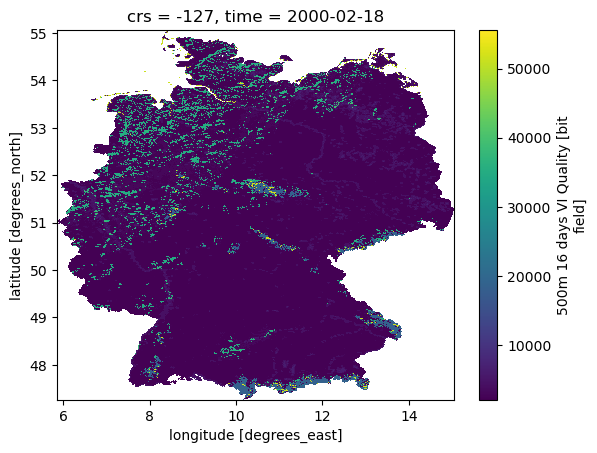

In [10]:
ndvi_full.QA.sel(time = "2000-02-18").plot()

In [11]:
# read in quality flag lookup table that was delivered with data to get information on quality flags
lut = pd.read_csv("./Raw/NDVI_MODIS/MOD13A1-061-500m-16-days-VI-Quality-lookup.csv")
lut

,Value,MODLAND,VI Usefulness,Aerosol Quantity,Adjacent cloud detected,Atmosphere BRDF Correction,Mixed Clouds,Land/Water Mask,Possible snow/ice,Possible shadow
0,2061,"VI produced, but check other QA",Decreasing quality (0011),Climatology,No,No,No,Land (Nothing else but land),No,No
1,2062,"Pixel produced, but most probably cloudy",Decreasing quality (0011),Climatology,No,No,No,Land (Nothing else but land),No,No
2,2065,"VI produced, but check other QA",Decreasing quality (0100),Climatology,No,No,No,Land (Nothing else but land),No,No
3,2066,"Pixel produced, but most probably cloudy",Decreasing quality (0100),Climatology,No,No,No,Land (Nothing else but land),No,No
4,2069,"VI produced, but check other QA",Decreasing quality (0101),Climatology,No,No,No,Land (Nothing else but land),No,No
...,...,...,...,...,...,...,...,...,...,...
610,56383,Pixel not produced due to other reasons than c...,Not useful for any other reason/not processed,Climatology,No,No,Yes,Shallow inland water,Yes,Yes
611,56562,"Pixel produced, but most probably cloudy",Lowest quality,High,No,No,Yes,Shallow inland water,Yes,Yes
612,56618,"Pixel produced, but most probably cloudy",Decreasing quality (1010),Climatology,Yes,No,Yes,Shallow inland water,Yes,Yes
613,56622,"Pixel produced, but most probably cloudy",Decreasing quality (1011),Climatology,Yes,No,Yes,Shallow inland water,Yes,Yes


In [12]:
# extract all quality flag values that are fit for our purpose and should be kept in the dataset
# sources: https://lpdaac.usgs.gov/documents/621/MOD13_User_Guide_V61.pdf and https://lpdaac.usgs.gov/resources/e-learning/working-appeears-netcdf-4-output-data-python/ 

# include good quality based on MODLAND
modland = ['VI produced with good quality', 'VI produced, but check other QA']
lut = lut[lut['MODLAND'].isin(modland)]

# exclude lower quality VI usefulness
VIU =["Lowest quality","Quality so low that it is not useful","L1B data faulty","Not useful for any other reason\/not processed"]
lut = lut[~lut['VI Usefulness'].isin(VIU)]

# include low or average aerosol quantity
AQ = ['Low','Average']
lut = lut[lut['Aerosol Quantity'].isin(AQ)]

# include where adjacent cloud, mixed clouds, or possible shadow were not detected
lut = lut[lut['Adjacent cloud detected'] == 'No' ]
lut = lut[lut['Mixed Clouds'] == 'No' ]
lut = lut[lut['Possible shadow'] == 'No' ]

# look at updated table
lut

<>:9: SyntaxWarning: invalid escape sequence '\/'
<>:9: SyntaxWarning: invalid escape sequence '\/'
C:\Users\irish\AppData\Local\Temp\ipykernel_14724\2231930751.py:9: SyntaxWarning: invalid escape sequence '\/'
  VIU =["Lowest quality","Quality so low that it is not useful","L1B data faulty","Not useful for any other reason\/not processed"]


,Value,MODLAND,VI Usefulness,Aerosol Quantity,Adjacent cloud detected,Atmosphere BRDF Correction,Mixed Clouds,Land/Water Mask,Possible snow/ice,Possible shadow
7,2116,VI produced with good quality,Lower quality,Low,No,No,No,Land (Nothing else but land),No,No
9,2120,VI produced with good quality,Decreasing quality (0010),Low,No,No,No,Land (Nothing else but land),No,No
11,2124,VI produced with good quality,Decreasing quality (0011),Low,No,No,No,Land (Nothing else but land),No,No
14,2185,"VI produced, but check other QA",Decreasing quality (0010),Average,No,No,No,Land (Nothing else but land),No,No
16,2189,"VI produced, but check other QA",Decreasing quality (0011),Average,No,No,No,Land (Nothing else but land),No,No
18,2193,"VI produced, but check other QA",Decreasing quality (0100),Average,No,No,No,Land (Nothing else but land),No,No
94,4164,VI produced with good quality,Lower quality,Low,No,No,No,Ocean coastlines and lake shorelines,No,No
96,4168,VI produced with good quality,Decreasing quality (0010),Low,No,No,No,Ocean coastlines and lake shorelines,No,No
98,4172,VI produced with good quality,Decreasing quality (0011),Low,No,No,No,Ocean coastlines and lake shorelines,No,No
101,4237,"VI produced, but check other QA",Decreasing quality (0011),Average,No,No,No,Ocean coastlines and lake shorelines,No,No


In [13]:
# extract quality flags that indicate good pixel quality
qa_tokeep = list(lut["Value"])

In [14]:
# get all dates that are stored in large dataset
dates = list(ndvi_full.time.values)

In [ ]:
# loop over dates to process each date seperately
# dataset is too large to be processed at once

for d in dates:
    
    # extract data of this date as xarray
    ndvi = ndvi_full.sel(time = d)

    # manually get time back as dimension, not just variable
    # time dimension was dropped when selecting
    ndvi = ndvi.expand_dims('time')

    # replace fill value with NA
    # valid ndvi range is -2000 to 10000, fill value is -3000, according to https://lpdaac.usgs.gov/documents/621/MOD13_User_Guide_V61.pdf 
    # but the scale factor of 0.0001 is automatically applied to the data, so we convert values smaller than -0.3 to NA
    ndvi['NDVI'] = xr.where((ndvi['NDVI'] > -0.3), ndvi['NDVI'], np.nan)

    # create a mask for the ndvi dataset that only keeps pixels of good quality
    # use quality flags that were just determined
    mask = ndvi["QA"].isin(qa_tokeep).compute()

    # mask data
    ndvi_masked = ndvi["NDVI"].where(mask, drop = False)

    # load forest area from ESA Landcover data for corresponding year
    # attention: forest data only available for 1992 - 2022 -> choose 2022 for ndvi data of 2022 - 2024
    year = int(str(d)[0:4])

    if year >= 2022:
        forest_year = 2022
    else: forest_year = year

    forest = xr.open_dataset(f"./Forest_GER/Forest_GER_{forest_year}.nc", 
                            decode_coords = "all", 
                            decode_times= True)
    
    # set crs for ndvi data
    ndvi_masked.rio.write_crs(4326, inplace = True)

    # set spatial dims again - otherwise resampling raises an error
    ndvi_masked.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace = True)

    # resample ndvi dataset to match resolution of forest dataset
    ndvi_match = ndvi_masked.rio.reproject_match(forest)

    # rename dimensions - they got renamed while resampling
    ndvi_match = ndvi_match.rename({'y':'lat', 'x':'lon'})

    # mask ndvi with forest data
    # broadleaved forest:
    ndvi_BL = ndvi_match.where(forest.lccs_class.sel(time=f"{forest_year}-01-01") == 60, 
                                drop = False)

    # needleleaved forest:
    NL_mask = forest.lccs_class.sel(time=f"{forest_year}-01-01").isin([70, 80]).compute()
    ndvi_NL = ndvi_match.where(NL_mask, drop = False)

    # compress data to reduce size
    comp = dict(zlib=True, complevel=4)
    ndvi_BL.encoding.update(comp)
    ndvi_NL.encoding.update(comp)
        
    # save as netCDF4 datasets
    date = ndvi_match.coords["time"].dt.strftime('%Y-%m-%d').values[0]
    ndvi_BL.to_netcdf(f"./NDVI/16Daily/{year}/NDVI_{date}_BL.nc")
    ndvi_NL.to_netcdf(f"./NDVI/16Daily/{year}/NDVI_{date}_NL.nc")

In [16]:
# load one processed dataset as example and plot to get an overview
ndvi_NL = xr.open_dataarray("./NDVI/16Daily/2000/NDVI_2000-02-18_NL.nc", decode_coords = "all", decode_times= True)
ndvi_NL

<xarray.DataArray 'NDVI' (time: 1, lat: 2952, lon: 3510)> Size: 83MB
[10361520 values with dtype=float64]
Coordinates:
    crs          int8 1B ...
  * time         (time) datetime64[ns] 8B 2000-02-18
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0

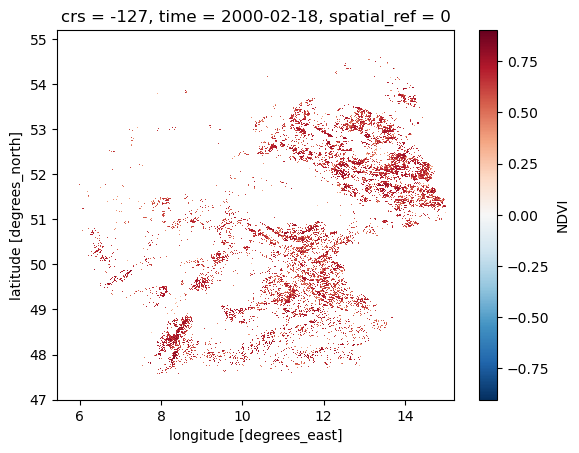

In [17]:
ndvi_NL.plot()

In [18]:
# to get more information on pixel quality:
# count quality flag frequencies and pixels of high quality per year
# read in again quality flag lookup table that was delivered with data
lut = pd.read_csv("./Raw/NDVI_MODIS/MOD13A1-061-500m-16-days-VI-Quality-lookup.csv")

In [19]:
# rename column with quality flags
lut.rename({"Value":'qa_flag'},axis=1, inplace= True)

In [20]:
# read in table with quality flag statistics that was also delivered with data
qa_stats = pd.read_csv("./Raw/NDVI_MODIS/MOD13A1-061-500m-16-days-VI-Quality-Statistics-QA.csv")

In [21]:
qa_stats

,File,aid,Date,2061,2062,2065,2066,2069,2070,2111,...,55781,55785,56358,56362,56366,56383,56562,56618,56622,56626
0,_500m_16_days_VI_Quality_2000049_aid0001,aid0001,2000-02-18,309.0,10122.0,5118.0,198640,27.0,28750.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,_500m_16_days_VI_Quality_2000065_aid0001,aid0001,2000-03-05,1001.0,121863.0,664.0,78411,NaN,2706.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,_500m_16_days_VI_Quality_2000081_aid0001,aid0001,2000-03-21,678.0,14895.0,392.0,18659,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,_500m_16_days_VI_Quality_2000097_aid0001,aid0001,2000-04-06,2054.0,1225.0,427.0,1440,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,_500m_16_days_VI_Quality_2000113_aid0001,aid0001,2000-04-22,301.0,15150.0,1184.0,5904,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,_500m_16_days_VI_Quality_2024289_aid0001,aid0001,2024-10-15,2.0,6574.0,1323.0,19552,137.0,28417.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
568,_500m_16_days_VI_Quality_2024305_aid0001,aid0001,2024-10-31,NaN,NaN,5659.0,294680,1248.0,444076.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
569,_500m_16_days_VI_Quality_2024321_aid0001,aid0001,2024-11-16,NaN,NaN,621799.0,28863,9185.0,141738.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
570,_500m_16_days_VI_Quality_2024337_aid0001,aid0001,2024-12-02,NaN,NaN,126636.0,503867,26020.0,728035.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# drop unneeded columns
qa_stats = qa_stats.drop(["File", "aid"], axis=1)

# extract year as new column
qa_stats["Year"] = qa_stats['Date'].astype(str).str[0:4]

In [23]:
# create empty lists for pixel counts
years = []
pixel_counts = []
high_quality_pixel_counts = []

In [24]:
# loop over each year to get yearly statistics 
for year in range(2000, 2025):

    # get all dates from this year and extract them
    qa_stats_yearly = qa_stats[(qa_stats["Year"] == str(year))]

    # drop unneeded columns
    qa_stats_yearly = qa_stats_yearly.drop(["Date", "Year"], axis=1)

    # calculate sum of flag counts of dates in each year to get flag frequencies for this year
    df_qa_freq = pd.DataFrame(qa_stats_yearly.sum())

    # create new column with quality flag
    df_qa_freq["qa_flag"] = df_qa_freq.index

    # reset index
    df_qa_freq.reset_index(drop = True, inplace = True)

    # rename column with counts
    df_qa_freq.rename({0:'qa_flag_freq'},axis=1, inplace= True)

    # convert values to integer
    df_qa_freq = df_qa_freq.astype(int)

    # add information from lookup table to flags
    df_qa_freq = pd.merge(df_qa_freq, lut, on = "qa_flag")

    # save quality flag frequencies as csv
    df_qa_freq.to_csv(f"./Tables/NDVI_Quality_Assessment/NDVI_QA_Flag_Frequency_{year}.csv")

    # extract all quality flag values that are fit for our purpose and should be kept in the dataset
    df_qa_tokeep = df_qa_freq[(df_qa_freq["qa_flag"].isin(qa_tokeep))]

    # append counts to lists    
    years.append(year)
    pixel_counts.append(sum(df_qa_freq.qa_flag_freq))
    high_quality_pixel_counts.append(sum(df_qa_tokeep.qa_flag_freq))

In [25]:
df_qa_pixel_counts = pd.DataFrame({"Year": years,
                                "Pixels": pixel_counts,
                                "High_Quality_Pixels": high_quality_pixel_counts})

In [26]:
df_qa_pixel_counts

,Year,Pixels,High_Quality_Pixels
0,2000,53097012,37909140
1,2001,61060953,40431311
2,2002,61061050,43762510
3,2003,61060090,44840255
4,2004,61061257,41323279
5,2005,61059813,46004176
6,2006,61061091,39742269
7,2007,61060589,43687501
8,2008,61061667,43375821
9,2009,61062031,42780430


In [27]:
# save pixel counts as csv
df_qa_pixel_counts.to_csv("./Tables/NDVI_Quality_Assessment/NDVI_QA_Pixel_Counts_2000-2024.csv")